# 堆叠自动编码器
编码器和解码器网络也可能有多层，使用更深的编码器和解码器网络可以使自编码器表示更复杂的特征，将一个编码器提取的特征作为输入传递到下一个编码器，这种结构被称为堆叠自编码器（或者深度自编码器）。

堆叠自编码器可以作为一个网络进行训练，训练目标是最小化重构误差；也可以首先使用之前学习的无监督方法对每个编码器/解码器网络进行预训练，然后对整个网络进行微调。有人指出，通过预训练（逐层贪婪训练），效果会更好。

使用逐层贪婪方法来训练堆叠自编码器，为了降低训练难度，这里使用共享权重，因此相应的编码器/解码器权重将是彼此的转置。

## 实例：利用 MNIST 数据训练堆叠编码器，并使用它来重构测试图像

1. 导入模块

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline

2. 加载数据集

In [2]:
mnist = input_data.read_data_sets('MNIST_data')
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


3. 定义类 StackedAutoencoder。__init__ 方法包括一个列表，其中包含每个自编码器中的诸多神经元，从第一个输入自编码器和学习率开始。由于每层都有不同的输入和输出维度，因此选择一个字典数据结构来表示每层的权重、偏置和输入

In [6]:
class StackAutoEncoder:
    """堆叠自动编码器"""
    
    def __init__(self, list1, eta=0.02):
        """
        list1: [input_dimension, hidden_layer_1, ... , hidden_layer_n]
        """
        N = len(list1) - 1
        self._m = list1[0]
        self.learning_rate = eta
        self.session = None
        
        # 构建计算图
        self._W = {}
        self._b = {}
        self._X = {}
        self._X['0'] = tf.placeholder(dtype='float', shape=[None, list1[0]])
        
        for i in range(N):
            
            layer = '{0}'.format(i + 1)
            print('AutoEncoder Layer {0}: {1} --> {2}'.format(layer, list1[i], list1[i + 1]))
            
            self._W['E' + layer] = tf.Variable(tf.random_normal(shape=[list1[i], list1[i + 1]]), name='WtsEncoder' + layer)
            self._b['E' + layer] = tf.Variable(np.zeros(list1[i + 1]).astype(np.float32), name='BiasEncoder' + layer)
            self._X[layer] = tf.placeholder(dtype='float', shape=[None, list1[i + 1]])
            
            self._W['D' + layer] = tf.transpose(self._W['E' + layer])    # 解码器权重与编码器共享
            self._b['D' + layer] = tf.Variable(np.zeros(list1[i]).astype(np.float32), name='BiasDecoder' + layer)
            self._X_noisy = tf.placeholder(dtype='float', shape=[None, self._m])
        
        # 建立计算图，在预训练时为每个自编码器定义优化参数，
        # 当上一个自编码器的输出作为当前自编码器的输入时，为其定义重构损失
        # 为此定义了方法 pretrain 和 one_pass，分别为每个自编码器返回编码器的训练操作和输出
        self.train_ops = {}
        self.out = {}
        for i in range(N):
            layer = '{0}'.format(i + 1)
            prev_layer = '{0}'.format(i)
            opt = self.pretrain(self._X[prev_layer], layer)
            self.train_ops[layer] = opt
            self.out[layer] = self.one_pass(
                self._X[prev_layer], self._W['E' + layer], self._b['E' + layer], self._b['D' + layer])
        
        # 在计算图中对整个堆叠自编码器进行微调，这里使用类方法 encoder 和 decoder 来实现
        self.y = self.encoder(self._X_noisy, N)    # 编码器输出
        self.r = self.decoder(self.y, N)           # 解码器输出
        
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        error = self._X['0'] - self.r    # 重构误差
        self._loss = tf.reduce_mean(tf.pow(error, 2))
        self._opt = optimizer.minimize(self._loss)
    
    def fit(self, Xtrain, Xtr_noisy, layers, epochs=1, batch_size=100):
        """自编码器训练"""
        
        N, D = Xtrain.shape
        num_batches = N // batch_size
        X_noisy = {}
        X = {}
        
        X_noisy['0'] = Xtr_noisy
        X['0'] = Xtrain
        
        # 预训练单层权重
        for i in range(layers):
            Xin = X[str(i)]
            print('Pretraining Layer ', i + 1)
            for e in range(5):
                for j in range(num_batches):
                    batch = Xin[j * batch_size: (j * batch_size + batch_size)]
                    self.session.run(self.train_ops[str(i + 1)], feed_dict={self._X[str(i)]: batch})
                    X[str(i + 1)] = self.session.run(
                        self.out[str(i + 1)], 
                        feed_dict={self._X[str(i)]: Xin}
                    )
        print('Pretraining Finished')
        
        # 整体同时训练，fine-tune
        obj = []
        for i in range(epochs):
            for j in range(num_batches):
                batch = Xtrain[j * batch_size: (j * batch_size + batch_size)]
                batch_noisy = Xtr_noisy[j * batch_size: (j * batch_size + batch_size)]
                _, ob = self.session.run(
                    [self._opt, self._loss],
                    feed_dict={self._X['0']: batch, self._X_noisy: batch_noisy}
                )
                if j % 100 == 0:
                    print('training epoch {0} batch {2} cost {1}'.format(i, ob, j))
                obj.append(ob)
        
        return obj
    
    def encoder(self, X, N):
        x = X
        for i in range(N):
            layer = '{0}'.format(i + 1)
            hiddenE = tf.nn.sigmoid(tf.matmul(x, self._W['E' + layer]) + self._b['E' + layer])
            x = hiddenE
        return x
    
    def decoder(self, X, N):
        x = X
        for i in range(N, 0, -1):
            layer = '{0}'.format(i)
            hiddenD = tf.nn.sigmoid(tf.matmul(x, self._W['D' + layer]) + self._b['D' + layer])
            x = hiddenD
        return x
    
    def set_session(self, session):
        self.session = session
    
    def reconstruct(self, x, n_layers):
        h = self.encoder(x, n_layers)
        r = self.decoder(h, n_layers)
        return self.session.run(r, feed_dict={self._X['0']: x})
    
    def pretrain(self, X, layer):
        y = tf.nn.sigmoid(tf.matmul(X, self._W['E' + layer]) + self._b['E' + layer])
        r = tf.nn.sigmoid(tf.matmul(y, self._W['D' + layer]) + self._b['D' + layer])
        # 目标函数
        error = X - r    # 重构误差
        loss = tf.reduce_mean(tf.pow(error, 2))
        opt = tf.train.AdamOptimizer(.001).minimize(
            loss, var_list=[self._W['E' + layer], self._b['E' + layer], self._b['D' + layer]])
        return opt
    
    def one_pass(self, X, W, b, c):
        h = tf.nn.sigmoid(tf.matmul(X, W) + b)
        return h
    

4. 使用 corrupt_img 函数为图像加入噪声，最后创建一个 StackAutoencoder 对象并对其进行训练

In [7]:
def corrupt_img(x, noise_factor=0.3):
    noisy_imgs = x + noise_factor * np.random.randn(*x.shape)
    noisy_imgs = np.clip(noisy_imgs, 0., 1.)
    return noisy_imgs

In [8]:
Xtrain = trX.astype(np.float32)
Xtrain_noisy = corrupt_img(Xtrain).astype(np.float32)
Xtest = teX.astype(np.float32)
Xtest_noisy = corrupt_img(Xtest).astype(np.float32)
_, m = Xtrain.shape

list1 = [m, 500, 50]    # 定义每层自编码器的神经元数量
n_layers = len(list1) - 1

stack_auto_encoder = StackAutoEncoder(list1)

# 变量初始化
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    stack_auto_encoder.set_session(sess)
    err = stack_auto_encoder.fit(Xtrain, Xtrain_noisy, n_layers, epochs=30)
    out = stack_auto_encoder.reconstruct(Xtest_noisy[:100], n_layers)

AutoEncoder Layer 1: 784 --> 500
AutoEncoder Layer 2: 500 --> 50
Pretraining Layer  1
Pretraining Layer  2
Pretraining Finished
training epoch 0 batch 0 cost 0.0982593446969986
training epoch 0 batch 100 cost 0.0743485763669014
training epoch 0 batch 200 cost 0.07117544114589691
training epoch 0 batch 300 cost 0.0678023025393486
training epoch 0 batch 400 cost 0.06337692588567734
training epoch 0 batch 500 cost 0.06018786504864693
training epoch 1 batch 0 cost 0.06139209866523743
training epoch 1 batch 100 cost 0.055769722908735275
training epoch 1 batch 200 cost 0.05097879096865654
training epoch 1 batch 300 cost 0.04792794957756996
training epoch 1 batch 400 cost 0.04812663793563843
training epoch 1 batch 500 cost 0.047136127948760986
training epoch 2 batch 0 cost 0.046312641352415085
training epoch 2 batch 100 cost 0.04409697279334068
training epoch 2 batch 200 cost 0.04112739861011505
training epoch 2 batch 300 cost 0.039703771471977234
training epoch 2 batch 400 cost 0.03923915326

training epoch 25 batch 300 cost 0.0245332270860672
training epoch 25 batch 400 cost 0.028159398585557938
training epoch 25 batch 500 cost 0.02610303834080696
training epoch 26 batch 0 cost 0.026052579283714294
training epoch 26 batch 100 cost 0.025894321501255035
training epoch 26 batch 200 cost 0.024527113884687424
training epoch 26 batch 300 cost 0.023736171424388885
training epoch 26 batch 400 cost 0.02733887918293476
training epoch 26 batch 500 cost 0.025837549939751625
training epoch 27 batch 0 cost 0.025105202570557594
training epoch 27 batch 100 cost 0.02463827095925808
training epoch 27 batch 200 cost 0.02407577820122242
training epoch 27 batch 300 cost 0.023544032126665115
training epoch 27 batch 400 cost 0.026093613356351852
training epoch 27 batch 500 cost 0.025555403903126717
training epoch 28 batch 0 cost 0.025049705058336258
training epoch 28 batch 100 cost 0.024253370240330696
training epoch 28 batch 200 cost 0.024024460464715958
training epoch 28 batch 300 cost 0.02338

5. 可视化 loss 变化曲线

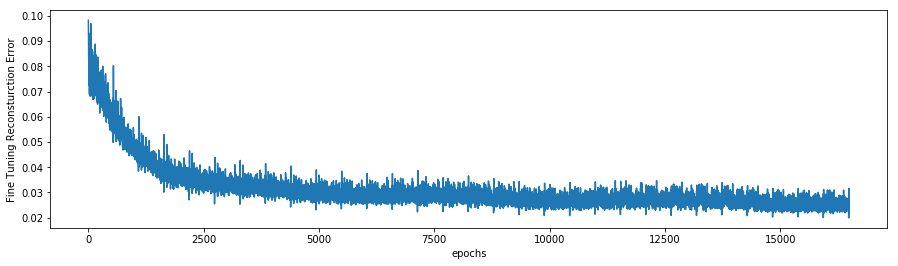

In [9]:
plt.figure(figsize=(15, 4))
plt.plot(err)
plt.xlabel('epochs')
plt.ylabel('Fine Tuning Reconsturction Error')
plt.show()

6. 测试堆叠自编码器性能

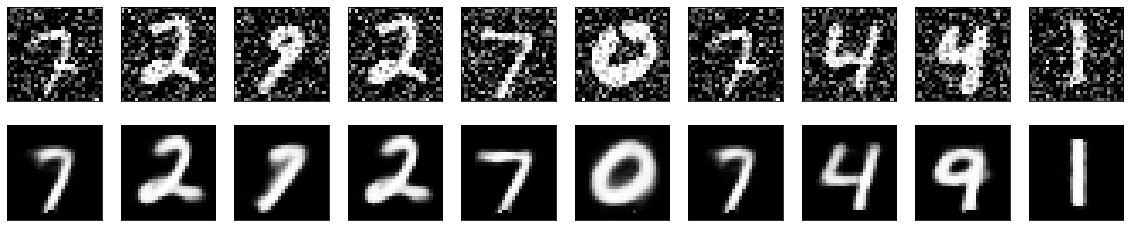

In [13]:
row, col = 2, 10
idx = np.random.randint(0, 100, row * col // 2)
f, axarr = plt.subplots(row, col, sharex=True, sharey=True, figsize=(20, 4))
for fig, row in zip([Xtest_noisy, out], axarr):
    for i, ax in zip(idx, row):
        ax.imshow(fig[i].reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)